# LLC Divergence and Curl

In [1]:
%matplotlib inline

In [40]:
# imports
from importlib import reload

import os
import numpy as np

import pandas
import xarray
import h5py

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo.plotting import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting
from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs

In [3]:
sns.set_style('whitegrid')
sns.set_context('notebook')

# Load Main Table

In [4]:
tbl_file = 's3://llc/Tables/test_uniform_r0.5_test.feather'
llc_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://llc/Tables/test_uniform_r0.5_test.feather


In [5]:
llc_table['DT'] = llc_table.T90 - llc_table.T10

In [26]:
llc_table

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,LL,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,DT
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.467546,...,647491,0,648.981934,-0.099179,-0.001986,0.059771,0.063255,0.141285,0.082805,0.190000
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-0.492408,...,384768,0,-513.771851,-0.008606,-0.042140,0.041484,0.108360,0.046431,0.037870,4.904001
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,3.271719,...,283882,0,345.448669,0.070156,-0.045817,0.022577,0.044823,0.099820,0.029986,0.958000
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.945127,...,613023,0,169.709839,0.081717,-0.010355,0.024675,0.039160,0.115622,0.034708,1.146000
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.364319,...,537161,0,349.981262,0.039346,0.019852,0.023803,0.031211,0.057416,0.030541,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781657,-78.124039,-164.077957,1766,11030,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.836020,...,595431,0,1108.595215,0.001224,0.004325,0.036770,0.033222,0.040823,0.032279,0.013000
781658,-77.981461,-162.126511,1772,11124,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.834905,...,81259,0,1109.360474,-0.007142,0.010525,0.025953,0.025552,0.029368,0.024206,0.008000
781659,-78.013351,-43.121677,1893,17073,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.880773,...,501586,0,1108.538086,-0.002059,-0.008371,0.037849,0.034990,0.040147,0.035554,0.005000
781660,-78.013466,-40.012012,1901,17210,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.878127,...,66695,0,1110.371094,-0.003489,-0.016292,0.037105,0.046364,0.042505,0.031199,0.004000


# Do an outlier

In [6]:
high_DT = llc_table.DT > 4.
i4000 = np.argmin(np.abs(llc_table[high_DT].LL + 4000.))
cutout = llc_table[high_DT].iloc[i4000]
cutout

lat                                                           35.3249
lon                                                          -71.7188
row                                                              9856
col                                                             15629
datetime                                          2011-11-30 00:00:00
LLC_file            s3://llc/ThetaUVSalt/LLC4320_2011-11-30T00_00_...
pp_file                  s3://llc/PreProc/LLC_uniform_test_preproc.h5
pp_root                                                       llc_std
field_size                                                         64
mean_temperature                                              21.7707
Tmin                                                           16.167
Tmax                                                           25.351
T90                                                            25.071
T10                                                            16.607
pp_idx              

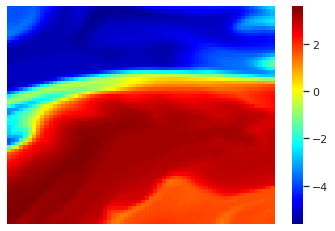

In [70]:
llc_plotting.show_cutout(cutout)

## Grab the velocity grids

In [9]:
with ulmo_io.open(cutout.LLC_file, 'rb') as f:
    ds = xarray.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 ...
    U        (j, i_g) float32 ...
    V        (j_g, i) float32 ...
    W        (k_l, j, i) float32 ...
    Salt     (j, i) float32 ...

In [13]:
ds.U

<xarray.DataArray 'U' (j: 12960, i_g: 17280)>
[223948800 values with dtype=float32]
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Attributes:
    standard_name:  sea_water_x_velocity
    mate:           V
    long_name:      Zonal Component of Velocity
    units:          m s-1

In [65]:
U_cutout = ds.U[cutout.row:cutout.row+cutout.field_size, 
                cutout.col:cutout.col+cutout.field_size]

<AxesSubplot:>

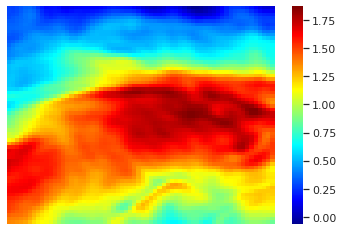

In [67]:
plotting.show_image(U_cutout)

In [66]:
V_cutout = ds.V[cutout.row:cutout.row+cutout.field_size, 
                cutout.col:cutout.col+cutout.field_size]

<AxesSubplot:>

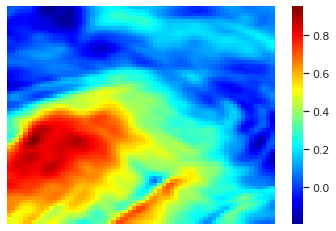

In [94]:
plotting.show_image(V_cutout)

# Divergence

## $\partial U / \partial x$

In [107]:
dUdx = np.gradient(U_cutout, axis=1)

<AxesSubplot:>

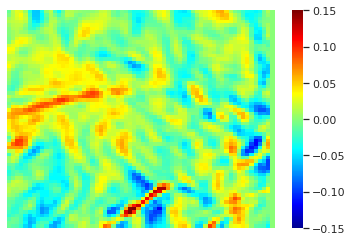

In [106]:
plotting.show_image(dUdx, vmnx=(-0.15, 0.15))

## $\partial V/\partial y$

In [109]:
dVdy = np.gradient(V_cutout, axis=0)

<AxesSubplot:>

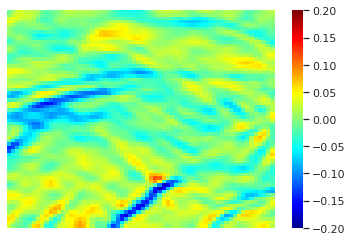

In [110]:
reload(plotting)
plotting.show_image(dVdy, vmnx=(-0.2, 0.2))

In [113]:
div = dUdx + dVdy

<AxesSubplot:>

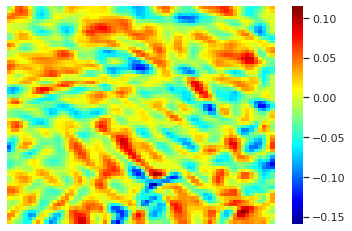

In [114]:
plotting.show_image(div)

# Curl

In [115]:
dUdy = np.gradient(U_cutout, axis=1)
dVdx = np.gradient(V_cutout, axis=0)
z_curl = dVdx - dUdy

<AxesSubplot:>

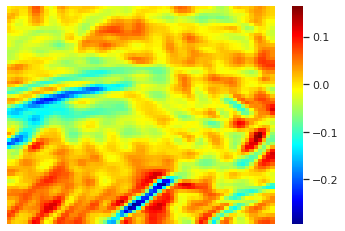

In [116]:
plotting.show_image(z_curl)

----

# Test $U, V$ orientations

In [10]:
coords = llc_io.load_coords()

Loading LLC coords from /data/Projects/Oceanography/data/LLC/LLC_coords.nc


In [11]:
coords

<xarray.Dataset>
Dimensions:  (x: 12960, y: 17280)
Coordinates:
    lon      (x, y) float32 -114.93228 -114.93217 ... -38.003056 -38.00089
    lat      (x, y) float32 -88.17715 -88.18007 -88.18299 ... 67.50019 67.49985
Dimensions without coordinates: x, y
Data variables:
    zero     (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

In [29]:
coords.lat[100, 500]

<xarray.DataArray 'lat' ()>
array(-89.42301, dtype=float32)
Coordinates:
    lon      float32 -63.812138
    lat      float32 -89.42301

In [23]:
coords.lat[10000, 17000]

<xarray.DataArray 'lat' ()>
array(37.062878, dtype=float32)
Coordinates:
    lon      float32 -43.822918
    lat      float32 37.062878

In [27]:
coords.lon[12000, 17000]

<xarray.DataArray 'lon' ()>
array(-43.636295, dtype=float32)
Coordinates:
    lon      float32 -43.636295
    lat      float32 61.56194

## $x$ is lat and corresponds to $j$ in datafile

## Larger view

In [60]:
cutout

lat                                                           35.3249
lon                                                          -71.7188
row                                                              9856
col                                                             15629
datetime                                          2011-11-30 00:00:00
LLC_file            s3://llc/ThetaUVSalt/LLC4320_2011-11-30T00_00_...
pp_file                  s3://llc/PreProc/LLC_uniform_test_preproc.h5
pp_root                                                       llc_std
field_size                                                         64
mean_temperature                                              21.7707
Tmin                                                           16.167
Tmax                                                           25.351
T90                                                            25.071
T10                                                            16.607
pp_idx              

In [34]:
ds.Theta[100:120, 100:120]

<xarray.DataArray 'Theta' (j: 20, i: 20)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * i        (i) int64 100 101 102 103 104 105 106 ... 114 115 116 117 118 119
  * j        (j) int64 100 101 102 103 104 105 106 ... 114 115 116 117 118 119
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

In [57]:
fov = 512*2
big_fov = ds.Theta[cutout.row- fov//2:cutout.row+ fov//2, cutout.col- fov//2:cutout.col+ fov//2]

<AxesSubplot:>

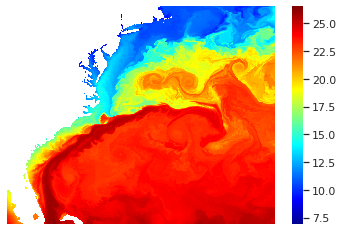

In [59]:
reload(plotting)
plotting.show_image(big_fov)

In [61]:
U_big = ds.U[cutout.row- fov//2:cutout.row+ fov//2, cutout.col- fov//2:cutout.col+ fov//2]

<AxesSubplot:>

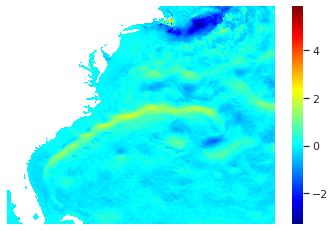

In [62]:
plotting.show_image(U_big)

In [63]:
V_big = ds.V[cutout.row- fov//2:cutout.row+ fov//2, cutout.col- fov//2:cutout.col+ fov//2]

<AxesSubplot:>

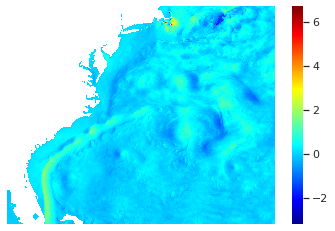

In [64]:
plotting.show_image(V_big)